## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

## **Task 2: RNN application -- Tweet Sentiment Analysis** (50%)

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimensionality reduction. 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1 LSTM Encoder (15%)

<font color="red"><strong>TODO:</strong></font> Create a single-layer LSTM network to classify tweets.
- Use one hot encoding to represent each word in the tweet.
- Set LSTM units to 128.
- Use Adam optimizer and set batch size to 32.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy. 

<font color="red"><strong>Hint:</strong></font> tf.one_hot and Keras functional API may be useful.
<br>https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [3]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################
from tensorflow.keras import layers
from keras.layers import Dropout

shape_unique = np.unique(train_tweets).shape
depth = shape_unique[0]
hot_1 = tf.one_hot(train_tweets, depth, dtype='float16') # (60000, 20, 6507)

model = tf.keras.Sequential()
model.add(layers.LSTM(128))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_LSTM = model.fit(hot_1, train_labels, batch_size=32, epochs=10) 

###################################################
# END TODO                                        #
###################################################

Epoch 1/10
1875/1875 [==============================] - 241s 127ms/step - loss: 0.5340 - accuracy: 0.7337
Epoch 2/10
1875/1875 [==============================] - 239s 127ms/step - loss: 0.4673 - accuracy: 0.7805
Epoch 3/10
1875/1875 [==============================] - 236s 126ms/step - loss: 0.4296 - accuracy: 0.8020
Epoch 4/10
1875/1875 [==============================] - 235s 125ms/step - loss: 0.3839 - accuracy: 0.8271
Epoch 5/10
1875/1875 [==============================] - 237s 126ms/step - loss: 0.3377 - accuracy: 0.8498
Epoch 6/10
1875/1875 [==============================] - 235s 125ms/step - loss: 0.2942 - accuracy: 0.8710
Epoch 7/10
1875/1875 [==============================] - 235s 125ms/step - loss: 0.2549 - accuracy: 0.8877
Epoch 8/10
1875/1875 [==============================] - 237s 126ms/step - loss: 0.2205 - accuracy: 0.9046
Epoch 9/10
1875/1875 [==============================] - 237s 126ms/step - loss: 0.1939 - accuracy: 0.9164
Epoch 10/10
1875/1875 [=======================

## Part 2: Embedding Lookup layer (20%)

### Define an embedding layer

It's not hard to imagine that in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. A useful technique is *Word Embedding*.

*Word Embedding*: instead of using a one-hot vector to represent each word, we can add a word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

<font color="red"><strong>TODO:</strong></font> Define a similar model as above with some improvements.
- Use an Embedding layer instead of one hot embedding.
- Write a custom training loop to train the model instead of using model.fit().
- Write a custom loop gives you complete control over how the model is trained.
- Report loss and accuracy for training and validation after each epoch.
- Display the loss value after every 500 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?

**Hints**: Refer to the link below.
<br>https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch


In [4]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################

import time
# embedding layer hyperparams
vocab_size = 10000
embeded_vector_size = 20

# model build up
model = tf.keras.Sequential()
model.add(layers.Embedding(vocab_size, embeded_vector_size, input_length=20))
model.add(layers.LSTM(128))
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# compiler build up
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.binary_crossentropy

# acc and loss metrics
train_loss_metric = tf.keras.metrics.BinaryCrossentropy()
val_loss_metric = tf.keras.metrics.BinaryCrossentropy()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

# input and output data preprocessing
batch_size = train_labels.shape[0] // 32
train_tweets_batch = np.split(train_tweets,batch_size)
train_labels_batch = np.split(train_labels,batch_size)
train_labels_batch = np.array(train_labels_batch, dtype=np.float32)

batch_size_test = test_labels.shape[0] // 20
test_tweets_batch = np.split(test_tweets,batch_size_test)
test_labels_batch = np.split(test_labels,batch_size_test)
test_labels_batch = np.array(test_labels_batch, dtype=np.float32)



epoch_num = 10

for epoch in range(epoch_num):
    start_time = time.time()
    print(f'\nStart of Epoch {epoch+1}')
    
    # computing training set
    for step, tweets in enumerate(train_tweets_batch):
        labels = train_labels_batch[step]
        labels = np.reshape(labels,(labels.shape[0],1))
        with tf.GradientTape() as tape:
            label_pred = model(tweets, training=True)
            loss = loss_fn(labels, label_pred, from_logits=True)
          
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # save the training acc and loss every batch
        train_acc_metric.update_state(labels, label_pred)
        train_loss_metric.update_state(labels, label_pred)
        
        # report loss every 500 sample
        if step % 500 == 0:
            train_loss = train_loss_metric.result()
            print(f'\nTraining loss at step {step} is {train_loss}.')
    
    # return epoch acc
    train_acc = train_acc_metric.result()
    print(f'\nTraining acc over epoch is {train_acc}.')
    train_acc_metric.reset_states()
    
    # return epoch loss
    train_loss = train_loss_metric.result()
    print(f'\nTraining loss over epoch is {train_loss}.')
    train_loss_metric.reset_states()
    
    # computing validation set
    for step_v, tweets_val in enumerate(test_tweets_batch):
        labels_val = test_labels_batch[step_v]
        labels_val = np.reshape(labels_val,(labels_val.shape[0],1))
        
        labels_v_pred = model(tweets_val, training=False)
        
        # save the validation acc and loss every batch
        val_acc_metric.update_state(labels_val, labels_v_pred)
        val_loss_metric.update_state(labels_val, labels_v_pred)
    
    # return validation acc
    val_acc = val_acc_metric.result()
    print(f'\nValidation acc over epoch is {val_acc}.')
    val_acc_metric.reset_states()
    
    # return validation loss
    val_loss = val_loss_metric.result()
    print(f'\nValidation loss over epoch is {val_loss}.')
    val_loss_metric.reset_states()
    
    print(f'\nTime taken:{time.time() - start_time} seconds.')
    
###################################################
# END TODO                                        #
###################################################


Start of Epoch 1


C:\Users\highm\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



Training loss at step 0 is 0.6917340755462646.

Training loss at step 500 is 0.5859501361846924.

Training loss at step 1000 is 0.556178867816925.

Training loss at step 1500 is 0.5401691198348999.

Training acc over epoch is 0.7340333461761475.

Training loss over epoch is 0.5321410894393921.

Validation acc over epoch is 0.7570000290870667.

Validation loss over epoch is 0.5038433074951172.

Time taken:120.91229343414307 seconds.

Start of Epoch 2

Training loss at step 0 is 0.44365525245666504.

Training loss at step 500 is 0.4681914746761322.

Training loss at step 1000 is 0.4686826169490814.

Training loss at step 1500 is 0.46658384799957275.

Training acc over epoch is 0.7821166515350342.

Training loss over epoch is 0.46570146083831787.

Validation acc over epoch is 0.7559999823570251.

Validation loss over epoch is 0.5052955746650696.

Time taken:120.53020596504211 seconds.

Start of Epoch 3

Training loss at step 0 is 0.37661212682724.

Training loss at step 500 is 0.44347822

## Part 3: Visualize word vectors via tSNE (15%)

<font color="red"><strong>TODO:</strong></font>
- First, you need to retrieve embedding matrix from the network.
- Then use tSNE to reduce each low-dimensional word vector into a 2D vector.
- And then, you should visualize some interesting word pairs in 2D panel. (You may find scatter function in matplotlib.pyplot useful.)

<font color="red"><strong>Hint:</strong></font> You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.


C:\Users\highm\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\highm\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, '2D Visualization of Male Female')

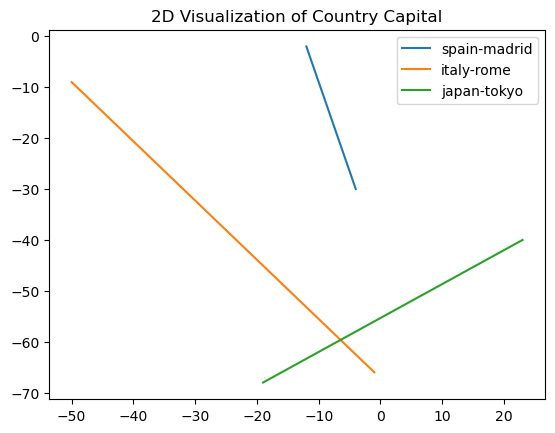

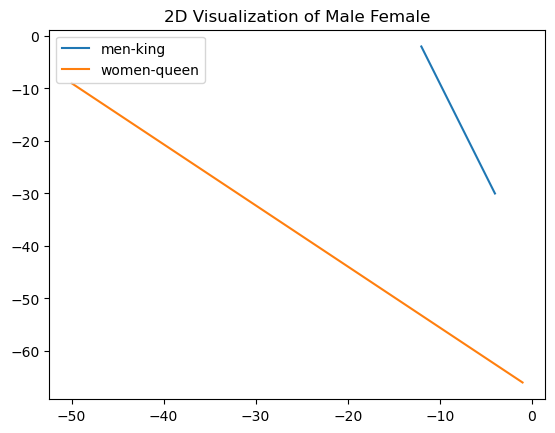

In [11]:
# word pairs provided
female_male = ["men", "king", "women", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
#you may try some other words as well

###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################

from sklearn.manifold import TSNE
embeddings = model.layers[0].get_weights()[0]
emb_tsne = TSNE(n_components=2).fit_transform(embeddings)

vocab_list = list(vocabulary)
indices =[]
points=[]

for word in country_capital:
    indices.append(vocab_list.index(word))

points = emb_tsne[indices]
plt.scatter(points[:, 0], points[:, 1], 20)    

# Country Capital Plot
plt.clf()
pair = 0
for text, pts in zip(country_capital, points):
    now = (int(pts[0]), int(pts[1]))
    pair += 1    
   
    if pair == 2:
        plt.plot(temp, now, label=temp_text+'-'+text)        
        plt.legend()
        pair = 0
    else:
        temp_text = text
        temp = now
plt.title('2D Visualization of Country Capital')

# Male Female Plot
plt.subplots(1)
pair = 0
for text, pts in zip(female_male, points):
    now = (int(pts[0]), int(pts[1]))
    pair += 1    
   
    if pair == 2:
        plt.plot(temp, now, label=temp_text+'-'+text)        
        plt.legend()
        pair = 0
    else:
        temp_text = text
        temp = now
plt.title('2D Visualization of Male Female')


###################################################
# END TODO                                        #
###################################################

<font color="red"><strong>Note:</strong></font> Install **sklearn** if you haven't already. 

```
> pip install sklearn
```

In [9]:
##Solution

from sklearn.manifold import TSNE
embeddings = model.layers[0].get_weights()[0]
emb_tsne = TSNE(n_components=2).fit_transform(embeddings)

C:\Users\highm\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\highm\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


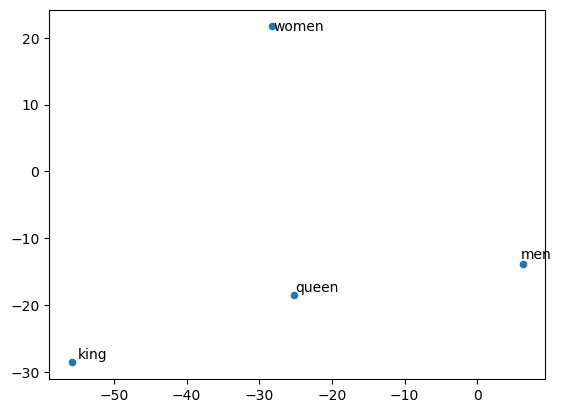

In [10]:
##Solution

vocab_list = list(vocabulary)
sample_words = female_male #["master", "teacher", "student", "graduate", "learning", "teach", "college", "campus"]
indices =[]
points = []

for word in sample_words:
    indices.append(vocab_list.index(word))
    
points = emb_tsne[indices]
plt.scatter(points[:, 0], points[:, 1], 20)

for text, pts in zip(sample_words, points):
    #plt.annotate(text, (X_tsne[idx,0],X_tsne[idx,1]), fontsize=20)
    plt.annotate(text, (int(pts[0]), int(pts[1])))
    